In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import tensorflow as tf
from keras.layers import Dense, LSTM, Input
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [5]:
ts = pd.read_csv('https://raw.githubusercontent.com/ranalytics/tsa-r/master/data/cryptos_price.csv')
ts=ts.sort_values(by='ds')
ts

,y,ds,coin
7754,4.530000,2018-01-01,tezos
2114,2.390000,2018-01-01,xrp
2819,1.010000,2018-01-01,tether
3524,229.030000,2018-01-01,litecoin
4229,8.840000,2018-01-01,eos
...,...,...,...
4230,0.055028,2019-12-06,stellar
3525,2.740000,2019-12-06,eos
2820,45.670000,2019-12-06,litecoin
2115,1.000000,2019-12-06,tether


In [6]:
bc = ts[ts['coin'] == 'bitcoin']

In [7]:
fig = px.line(bc,
              x="ds", y=bc.y,
              # line_shape="spline",
              render_mode="svg", log_y=False)


fig.show()

In [8]:
bc = bc[['ds', 'y']]
bc

,ds,y
704,2018-01-01,13657.20
703,2018-01-02,14982.10
702,2018-01-03,15201.00
701,2018-01-04,15599.20
700,2018-01-05,17429.50
...,...,...
4,2019-12-02,7321.99
3,2019-12-03,7320.15
2,2019-12-04,7252.03
1,2019-12-05,7448.31


In [9]:
# мы все знаем что для погноза нужны фичи, а их нет, поэтому в качестве их будем
# использовать сдвинутые на N отсчетов значения самого временного ряда
bc_diff = bc.copy()
bc_diff['prev_y'] = bc_diff['y'].shift(1)
bc_diff = bc_diff.dropna()
bc_diff['diff'] = (bc_diff['y'] - bc_diff['prev_y'])

In [13]:
bc_diff.head()

,ds,y,prev_y,diff
703,2018-01-02,14982.1,13657.2,1324.9
702,2018-01-03,15201.0,14982.1,218.9
701,2018-01-04,15599.2,15201.0,398.2
700,2018-01-05,17429.5,15599.2,1830.3
699,2018-01-06,17527.0,17429.5,97.5


In [14]:
# Добавим фичей в датафрейм
for i in range(1, 15):  # Создадим временной лаг на N дней
    bc_diff[f'Lag_{i}'] = bc_diff['y'].shift(i)

# удалим строки с NaN
bc_diff.dropna(inplace=True)

In [17]:
bc_mod = bc_diff.iloc[:,3:]
bc_mod.head()

,diff,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14
689,-2329.3,13819.8,13772.0,14360.2,13980.6,13405.8,14973.3,14595.4,15170.1,16477.6,17527.0,17429.5,15599.2,15201.0,14982.1
688,-301.9,11490.5,13819.8,13772.0,14360.2,13980.6,13405.8,14973.3,14595.4,15170.1,16477.6,17527.0,17429.5,15599.2,15201.0
687,286.3,11188.6,11490.5,13819.8,13772.0,14360.2,13980.6,13405.8,14973.3,14595.4,15170.1,16477.6,17527.0,17429.5,15599.2
686,132.5,11474.9,11188.6,11490.5,13819.8,13772.0,14360.2,13980.6,13405.8,14973.3,14595.4,15170.1,16477.6,17527.0,17429.5
685,1291.8,11607.4,11474.9,11188.6,11490.5,13819.8,13772.0,14360.2,13980.6,13405.8,14973.3,14595.4,15170.1,16477.6,17527.0


In [18]:
PREIODS=120
train_set, test_set = bc_mod[0:-PREIODS].values, bc_mod[-PREIODS:].values

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

In [20]:
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

In [21]:
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [22]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [23]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [24]:
BATCH_SIZE=1
BUFFER_SIZE = 10
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

2024-09-26 12:42:31.130715: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-26 12:42:31.130757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-26 12:42:31.130775: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-26 12:42:31.130860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-26 12:42:31.130904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:

model = Sequential()
model.add(Input(batch_shape=(1, X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, stateful=True))
model.add(Dense(1))

opt = SGD(lr=0.01, momentum=0.9, clipvalue=1.0)

model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 32)                   6016      
                                                                 
 dense_1 (Dense)             (1, 1)                    33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, shuffle=True, validation_split =0.2,
                    steps_per_epoch= 30, validation_steps = 5)

Epoch 1/50


2024-09-26 12:42:57.015878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-26 12:42:57.108612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-26 12:42:59.247801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 4s 14ms/step - loss: 0.0862 - val_loss: 0.0449
Epoch 2/50
11/30 [==========>...................] - ETA: 0s - loss: 0.0395

2024-09-26 12:43:00.766502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-26 12:43:00.808986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 6ms/step - loss: 0.0433 - val_loss: 0.0207
Epoch 3/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0906 - val_loss: 0.0169
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0046
Epoch 5/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0376 - val_loss: 7.1518e-04
Epoch 7/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0830 - val_loss: 0.0031
Epoch 8/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0262 - val_loss: 8.9607e-04
Epoch 9/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0288 - val_loss: 0.0166
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.0610
Epoch 11/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0578 - val_loss: 0.0067
Epoch 12/50
30/30 [==

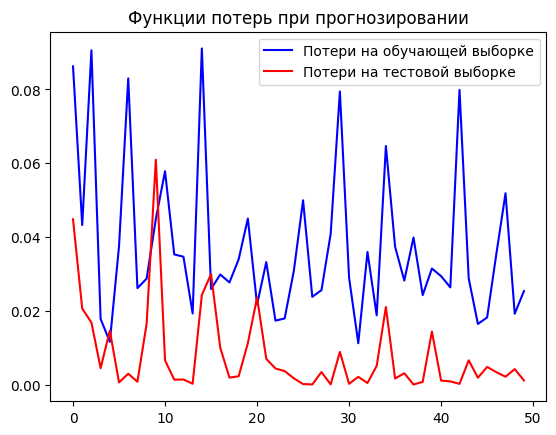

In [30]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'r', label='Потери на тестовой выборке')
    plt.title(title)
    plt.legend()

    plt.show()
plot_train_history(history, 'Функции потерь при прогнозировании')

In [31]:
y_pred = model.predict(X_test,batch_size=1)

2024-09-26 12:43:28.091058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-26 12:43:28.130353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 1s 3ms/step


In [32]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [33]:
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.27454835  0.64974336  0.64512465  0.48180958  0.54069065  0.39047273
   0.29253937  0.24081032  0.20048704  0.03450687 -0.10839006 -0.12074395
  -0.11602604 -0.12654791 -0.07159852]]
[[ 0.23377314  0.63018944  0.64974336  0.56520105  0.48180958  0.54069065
   0.31783643  0.29253937  0.22034736  0.08194193 -0.04146186 -0.10839006
  -0.12074395 -0.11602604 -0.12654791]]
[[ 0.21002893  0.53401291  0.63018944  0.56959538  0.56520105  0.48180958
   0.46020718  0.31783643  0.27122331  0.0998411   0.00248981 -0.04146186
  -0.10839006 -0.12074395 -0.11602604]]
[[ 0.19296622  0.56605663  0.53401291  0.55099142  0.56959538  0.56520105
   0.40440198  0.46020718  0.29610319  0.14569317  0.01907456  0.00248981
  -0.04146186 -0.10839006 -0.12074395]]
[[ 0.18359871  0.53941779  0.56605663  0.45948735  0.55099142  0.56959538
   0.4834372   0.40440198  0.43612601  0.16811622  0.0615595   0.01907456
   0.00248981 -0.04146186 -0.10839006]]
[[ 0.17891243  0.44742342  0.53941779  0.48997432  0.4594873

In [34]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [36]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
pd.DataFrame(pred_test_set_inverted).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-21.666482,11966.41,11941.97,11478.17,11805.65,10970.18,10821.73,10518.17,10399.67,10085.63,9607.42,9519.15,9552.86,9477.68,9870.30
1,-95.492038,11862.94,11966.41,11941.97,11478.17,11805.65,10970.18,10821.73,10518.17,10399.67,10085.63,9607.42,9519.15,9552.86,9477.68
2,-138.482118,11354.02,11862.94,11966.41,11941.97,11478.17,11805.65,10970.18,10821.73,10518.17,10399.67,10085.63,9607.42,9519.15,9552.86
3,-169.375005,11523.58,11354.02,11862.94,11966.41,11941.97,11478.17,11805.65,10970.18,10821.73,10518.17,10399.67,10085.63,9607.42,9519.15
4,-186.335352,11382.62,11523.58,11354.02,11862.94,11966.41,11941.97,11478.17,11805.65,10970.18,10821.73,10518.17,10399.67,10085.63,9607.42


In [37]:
pred_test_set_inverted[:,0]

array([-2.16664817e+01, -9.54920376e+01, -1.38482118e+02, -1.69375005e+02,
       -1.86335352e+02, -1.94820098e+02, -1.91647144e+02, -1.93365347e+02,
       -1.78540277e+02, -1.52942212e+02, -1.25371529e+02, -1.10844445e+02,
       -8.26006818e+01, -4.34113637e+01, -1.21929712e+01,  4.01780941e+00,
        2.34718253e+01,  2.91464349e+01,  1.61515865e+01, -7.27377012e-02,
        1.83318778e+00,  1.29457985e+01,  2.05536906e+01,  2.95041804e+01,
        3.91958455e+01,  3.62906608e+01,  2.88381695e+01,  2.89379929e+01,
        3.60119107e+01,  4.30824831e+01,  4.56829096e+01,  4.78404441e+01,
        3.70415486e+01,  1.53576398e+01, -7.71262722e+00, -1.96799421e+01,
       -2.01876925e+01, -1.83591976e+01, -1.53821400e+01, -8.37254084e+00,
        1.30606627e+00,  1.06421982e+01,  1.18521657e+01,  1.13144144e+01,
        1.00340309e+01,  7.86176575e+00,  1.07379207e+01,  2.20151591e+01,
        2.82214767e+01,  4.07356080e+01,  5.18031633e+01,  6.42068952e+01,
        6.97993259e+01,  

In [39]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(bc_diff[-(PREIODS):].ds)
act_sales = list(bc_diff[-(PREIODS):].y)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_y'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['ds'] = sales_dates[index]
    result_list.append(result_dict)
bc_result = pd.DataFrame(result_list)
bc_result.head()

,pred_y,ds
0,11841,2019-08-09
1,11258,2019-08-10
2,11385,2019-08-11
3,11213,2019-08-12
4,10709,2019-08-13


In [40]:
bc_pred = pd.merge(bc_diff,bc_result,on='ds',how='left')
bc_pred[['ds',	'y',	'pred_y']].tail(10)

,ds,y,pred_y
680,2019-11-27,7531.66,7656.0
681,2019-11-28,7463.11,7586.0
682,2019-11-29,7761.24,7888.0
683,2019-11-30,7569.63,7696.0
684,2019-12-01,7424.29,7555.0
685,2019-12-02,7321.99,7454.0
686,2019-12-03,7320.15,7453.0
687,2019-12-04,7252.03,7381.0
688,2019-12-05,7448.31,7571.0
689,2019-12-06,7547.00,7656.0


In [41]:
fig = px.line(bc_pred,
              x="ds", y=bc_pred["y"],
              # line_shape="spline",
              render_mode="svg", log_y=False)

fig.add_scatter(x=bc_pred["ds"],  y=bc_pred["pred_y"],mode='lines', name='предсказание')

fig.show()